
SchizoNet is a deep learning project that uses EEG signals to classify schizophrenia. The repo contains code for preprocessing the data, building a CNN, and evaluating the model's performance. 

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix

from tqdm.notebook import tqdm
!pip install python_speech_features
from python_speech_features import mfcc, logfbank

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
drive_path = '/content/drive'
from google.colab import drive
drive.mount(drive_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Data/ERPdata.csv")


This strategy extracts the unique time stamps from EEG data, calculates the time duration between consecutive data points, and uses this duration to compute the sample rate ($F_s$) in Hz.

$F_{s}=\frac{1}{t_j-t_i}$

In [5]:
time_axis = df['time_ms'].unique()
sample_rate = (1/(time_axis[1]-time_axis[0]))*1000
del df
print('Sample Rate:', sample_rate,'Hz')

Sample Rate: 1023.9606799099312 Hz


In [7]:
demographic = pd.read_csv("/content/drive/MyDrive/Data/demographic.csv")
diagnosis_dict = dict(zip(demographic.subject, demographic[" group"]))
column_list = pd.read_csv("/content/drive/MyDrive/Data/columnLabels.csv").columns
electrodes= list(pd.read_csv('/content/drive/MyDrive/Data/columnLabels.csv').columns[4:])

N_PERSON = 81
N_AVERAGED = 16
x_count = 0
num_electrodes = len(electrodes)
num_rows = 81 * 100
num_cols = 9216 * (num_electrodes // N_AVERAGED)
X = np.zeros((num_rows, num_cols), dtype=np.float32)
Y = np.zeros(len(X))

In [ ]:
def averaged_by_N_rows(a, n):
    assert a.ndim == 2, "Input matrix must be 2-dimensional"
    assert a.shape[0] % n == 0, "Number of rows in the input matrix must be divisible by n"
    return np.mean(a.reshape(-1, n, a.shape[1]), axis=1)

#Data Preprocessing

In [ ]:

for i in tqdm(range(N_PERSON)):

    person = str(i+1)
    csv_path = f"{'/content/drive/MyDrive/Data'}/{person}.csv/{person}.csv"
    df = pd.read_csv(csv_path, header=None, names=column_list)
    grouped_trials = df.groupby("trial")
    
    for trial_number, trial_data in grouped_trials:
        number_of_trials = len(trial_data)
        if number_of_trials == 9216:
            current_sample_matrix = trial_data[electrodes].values
            averaged_by_N = averaged_by_N_rows(current_sample_matrix, n=N_AVERAGED)
            averaged_by_N_big_vec = averaged_by_N.reshape(-1)
            np.append(X,averaged_by_N_big_vec.astype(np.float32))
            np.append(Y,diagnosis_dict[int(person)])

  0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
np.save('/content/drive/MyDrive/Data/X.npy', X);
np.save('/content/drive/MyDrive/Data/Y.npy', Y);

In [8]:
X = np.load('/content/drive/MyDrive/Data/X.npy')
Y = np.load('/content/drive/MyDrive/Data/Y.npy')

In [ ]:
X_norm = (normalize(X.reshape(-1, 70), axis=0, norm='max')).reshape(X.shape)

X_norm_2d = (X_norm.reshape(X_norm.shape[0], len(electrodes), X_norm.shape[1] // len(electrodes), 1))



MFCC works by transforming the signal into a logarithmic-scale mel frequency spectrum, decorrelating the spectral components using a discrete cosine transform, and taking the logarithm of the resulting coefficients to obtain a compact representation of the audio signal. It is a great choice for feature extraction.

In [ ]:
X_mffc = np.zeros((X_norm_2d.shape[0],X_norm_2d.shape[1],56,13))
for i in tqdm(range(X_norm_2d.shape[0])):
  for j in (range(X_norm_2d.shape[1])):
    X_mffc[i][j] =mfcc(X_norm_2d[i][j],sample_rate,numcep=13,nfilt=26,nfft=1103)
np.save('/content/drive/MyDrive/Data/X_mffc.npy', X_mffc);

  0%|          | 0/7092 [00:00<?, ?it/s]

In [6]:
X_mffc = np.load('/content/drive/MyDrive/Data/X_mffc.npy')

In [9]:
dataset = TensorDataset(torch.Tensor(X_mffc), torch.Tensor(Y).long())

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size 

indices = list(range(dataset_size))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

batch_size = 256

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

#Convolutional Model

In [10]:
import torch
import torch.nn as nn

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=70, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        
        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 7 * 2, 512)
        self.fc2 = nn.Linear(512, 2)
        
        # Activation function
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        # Input shape: (batch_size, 70, 56, 13)
        
        # Convolutional layers with ReLU activation and pooling
        x = self.conv1(x)
        x = self.tanh(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.tanh(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.tanh(x)
        x = self.pool(x)
        
        # Flatten the output from the convolutional layers
        x = x.view(-1, 128 * 7 * 2)
        
        # Fully connected layers with ReLU activation
        x = self.fc1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = torch.sigmoid(x)

        return x


In [11]:
net = NeuralNet()
net.to(device)

NeuralNet(
  (conv1): Conv2d(70, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1792, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
)

In [86]:
for i, data in enumerate(train_loader):
    inputs, labels = data[0].to(device), data[1].to(device)
    print(f'input shape: {inputs.shape}')
    print(f'after network shape: {net(inputs).shape}')
    break

input shape: torch.Size([256, 70, 56, 13])
after network shape: torch.Size([256, 2])


In [12]:
import torch.optim as optim

criterion = nn.BCELoss()
weight_decay=0.001
optimizer = optim.Adam(net.parameters(), lr=0.000085, weight_decay=weight_decay)

def train_one_epoch():
  net.train(True)

  running_loss = 0.0
  running_accuracy = 0.0

  for batch_index, data in enumerate(train_loader):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs = net(inputs) # shape: [batch_size, 2]
    correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
    running_accuracy += correct / batch_size
    labels = torch.nn.functional.one_hot(labels, num_classes=2)
    loss = criterion(outputs, labels.float())
    l2_reg = None
    for param in net.parameters():
        if l2_reg is None:
          l2_reg = param.norm(2)
        else:
          l2_reg = l2_reg + param.norm(2)
    loss = loss + weight_decay * l2_reg
    running_loss += loss.item()
    loss.backward()
    optimizer.step()

  running_loss = running_loss / len(train_loader)
  running_accuracy = (running_accuracy / len(train_loader)) * 100

  print('Loss: {0:.3f},Accuracy: {1:.1f}%'.format(running_loss,
                                                            running_accuracy))
  print('***************************************************')
  print()

  return running_loss, running_accuracy

#Training

In [13]:
num_epochs = 50
loss = []
acc = []
for epoch_index in range(num_epochs):
    print(f'Epoch: {epoch_index + 1}\n')
    
    _loss, _acc = train_one_epoch()
    loss.append(_loss)
    acc.append(_acc)
        

print('Finished Training')

Epoch: 1

Loss: 0.727,Accuracy: 49.4%
***************************************************

Epoch: 2

Loss: 0.720,Accuracy: 55.7%
***************************************************

Epoch: 3

Loss: 0.701,Accuracy: 59.3%
***************************************************

Epoch: 4

Loss: 0.688,Accuracy: 59.1%
***************************************************

Epoch: 5

Loss: 0.659,Accuracy: 62.0%
***************************************************

Epoch: 6

Loss: 0.640,Accuracy: 64.2%
***************************************************

Epoch: 7

Loss: 0.611,Accuracy: 67.0%
***************************************************

Epoch: 8

Loss: 0.587,Accuracy: 68.6%
***************************************************

Epoch: 9

Loss: 0.564,Accuracy: 70.0%
***************************************************

Epoch: 10

Loss: 0.542,Accuracy: 72.2%
***************************************************

Epoch: 11

Loss: 0.503,Accuracy: 75.6%
**************************************************

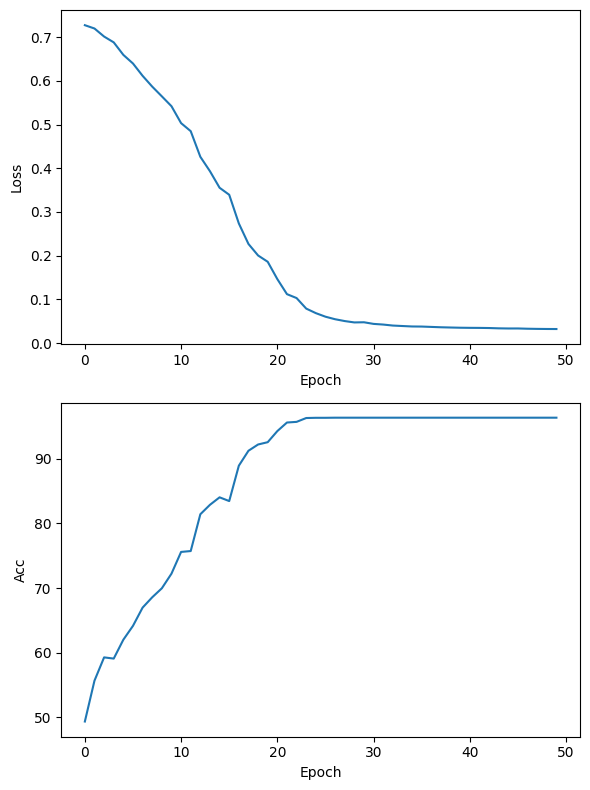

In [14]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))

axs[0].plot(loss)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].plot(acc)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Acc')

plt.tight_layout()
plt.show()